# 빵형과 함께하는 진화알고리즘으로 그림그리기

![image](https://i.ytimg.com/vi/K19IA240mU4/hqdefault.jpg?sqp=-oaymwEZCPYBEIoBSFXyq4qpAwsIARUAAIhCGAFwAQ==&rs=AOn4CLBTsCoPY2TuQ0feLAn9EgFDX9h17A)

[본문 유튜브 링크](https://www.youtube.com/watch?v=K19IA240mU4)  
[본문 깃허브 링크](https://github.com/kairess/genetic_image)

In [9]:
import cv2, random, os, sys
import numpy as np
from copy import deepcopy
from skimage.measure import compare_mse
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

필요한 모듈들을 import 합니다.

In [10]:
filepath = 'spongebob.jpg'
filename, ext = os.path.splitext(os.path.basename(filepath))

입력받은 이미지를 파일이름과 경로로 나누어 저장합니다.

In [11]:
img = cv2.imread(filepath)
height, width, channels = img.shape

경로에 저장된 이미지를 img 변수에 초기화시켜주고 세로, 가로, 채널(RGB)로 나누어줍니다.

In [12]:
# hyperparameters
n_initial_genes = 50
n_population = 50
prob_mutation = 0.01
prob_add = 0.3
prob_remove = 0.2

min_radius, max_radius = 5, 15
save_every_n_iter = 100

Hyperparameter(하이퍼 파라미터; 실행 전 미리 정해주는 파라미터 초기값들)
* 1세대 유전자 갯수 : 50
* 이후 세대들의 유전자 갯수 : 50
* 변이율 : 0.01(1%)
* 추가될 확률 : 0.3(30%)
* 제거될 확률 : 0.2(20%)

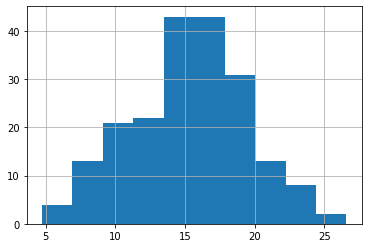

In [13]:
# Gene
class Gene():
  def __init__(self):
    self.center = np.array([random.randint(0, width), random.randint(0, height)])
    self.radius = random.randint(min_radius, max_radius)
    self.color = np.array([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

  def mutate(self):
    mutation_size = max(1, int(round(random.gauss(15, 4)))) / 100

    r = random.uniform(0, 1)
    if r < 0.33: # radius
      self.radius = np.clip(random.randint(
        int(self.radius * (1 - mutation_size)),
        int(self.radius * (1 + mutation_size))
      ), 1, 100)
    elif r < 0.66: # center
      self.center = np.array([
        np.clip(random.randint(
          int(self.center[0] * (1 - mutation_size)),
          int(self.center[0] * (1 + mutation_size))),
        0, width),
        np.clip(random.randint(
          int(self.center[1] * (1 - mutation_size)),
          int(self.center[1] * (1 + mutation_size))),
        0, height)
      ])
    else: # color
      self.color = np.array([
        np.clip(random.randint(
          int(self.color[0] * (1 - mutation_size)),
          int(self.color[0] * (1 + mutation_size))),
        0, 255),
        np.clip(random.randint(
          int(self.color[1] * (1 - mutation_size)),
          int(self.color[1] * (1 + mutation_size))),
        0, 255),
        np.clip(random.randint(
          int(self.color[2] * (1 - mutation_size)),
          int(self.color[2] * (1 + mutation_size))),
        0, 255)
      ])

s3 = pd.Series(np.random.normal(15,4,size=200))
s3.hist()

유전자 클래스 ; 유전자의 파라미터(성질)을 정의합니다.  
* def __init__(self) : 유전자의 파라미터(인스턴스)를 선언하고 초기값을 넣어줍니다.  
    * center : 유전자 중앙의 좌표값, ndarray(`0~width` 랜덤값, `0~height` 랜덤값) 타입  
    * radius : 유전자의 반지름 길이, int(`min~max` 랜덤값) 타입  
    * color : 유전자의 색깔, ndarray(`0~255` Blue 랜덤값, `0~255` Green 랜덤값, `0~255` Red 랜덤값)  
        
        
* def mutate(self) : 유전자의 변이율을 설정하고 변이율 만큼 변이시켜줍니다.  
  * 변이율 : 평균 15, 표준편차 4인 정규분포 랜덤을 생성, 0.01(1%) ~ 1.00(100%) 사이의 값을 가지도록 합니다.
  * 1/3 확률 : 반지름을 변이율 만큼 변이
  * 1/3 확률 : 위치를 변이율 만큼 변이
  * 1/3 확률 : 색깔을 변이율 만큼 변이

In [14]:
# compute fitness
def compute_fitness(genome):
  out = np.ones((height, width, channels), dtype=np.uint8) * 255
    
  for gene in genome:
    cv2.circle(out, center=tuple(gene.center), radius=gene.radius, color=(int(gene.color[0]), int(gene.color[1]), int(gene.color[2])), thickness=-1)

  # mean squared error
  fitness = 255. / compare_mse(img, out)

  return fitness, out

메인 클래스 ; 원본이미지와 생성된 이미지를 비교합니다
* 이미지와 같은 세로,가로,채널 크기를 가진 ndarray 이미지를 생성합니다
* 입력으로 받은 유전자에 따라 생성한 이미지에 Circle을 그립니다.
* 원본 이미지와 얼마나 비슷한지 fitness를 측정합니다

In [15]:
# compute population
def compute_population(g):
  genome = deepcopy(g)
  # mutation
  if len(genome) < 200:
    for gene in genome:
      if random.uniform(0, 1) < prob_mutation:
        gene.mutate()
  else:
    for gene in random.sample(genome, k=int(len(genome) * prob_mutation)):
      gene.mutate()

  # add gene
  if random.uniform(0, 1) < prob_add:
    genome.append(Gene())

  # remove gene
  if len(genome) > 0 and random.uniform(0, 1) < prob_remove:
    genome.remove(random.choice(genome))

  # compute fitness
  new_fitness, new_out = compute_fitness(genome)

  return new_fitness, genome, new_out

메인 클래스 ; 유전자의 인구를 조절합니다
* 유전자들의 리스트를 입력으로 받습니다  
* 유전자가 200개보다 적으면 변이될 확률에 따라서 하나씩 변이시킵니다  
* 유전자가 200개보다 많다면 변이될 확률에 따라서 k개만큼 뽑아서 한번에 변이시킵니다  
  
    
* 유전자가 추가될 확률에 따라 유전자를 추가해줍니다.
* 유전자가 제거될 확률에 따라 유전자를 제거해줍니다.
* 새롭게 fitness를 측정해줍니다

In [16]:
# main
if __name__ == '__main__':
  os.makedirs('result', exist_ok=True)

  p = mp.Pool(mp.cpu_count() - 1)

가장 우월 유전자를 미리 지정해둔 유전자 갯수만큼 만들어주고 유전자 인구를 조절해줍니다.

('일치율 = 1.7598951319890594%', <matplotlib.image.AxesImage at 0x2db5d39a9b0>)

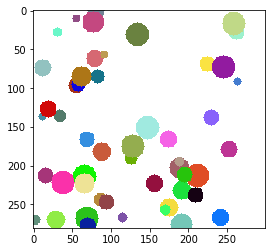

In [19]:
# 1st gene
best_genome = [Gene() for _ in range(n_initial_genes)]

best_fitness, best_out = compute_fitness(best_genome)

n_gen = 0

"일치율 = " + str(best_fitness*100) + "%", plt.imshow(best_out)

1세대 유전자 갯수만큼 유전자를 생성해주고, 우월 유전자 리스트에 넣어줍니다.  
우월 유전자 fitness를 측정하고 그 중에 가장 우월한 유전자를 저장합니다. 처음에는 엄청 낮은 값이 나오겠죠?

In [ ]:
  while True:
    try:
      results = p.map(compute_population, [deepcopy(best_genome)] * n_population)
    except KeyboardInterrupt:
      p.close()
      break

가장 우월 유전자를 미리 지정해둔 유전자 갯수만큼 만들어주고 유전자 인구를 조절해줍니다.

In [ ]:
    results.append([best_fitness, best_genome, best_out])

    new_fitnesses, new_genomes, new_outs = zip(*results)

    best_result = sorted(zip(new_fitnesses, new_genomes, new_outs), key=lambda x: x[0], reverse=True)

    best_fitness, best_genome, best_out = best_result[0]

`result` 리스트에 세대당 fitness, 우월 유전자들 그리고 가장 우월한 유전자를 세대마다 추가해줍니다.  
멀티 프로세싱을 위해 우리가 만든 새로운 이미지에 대한 fitness, 유전자들, 그리고 그린 이미지를 뽑아줍니다.  
그리고 이 세개를 묶고(`zip`), fitness(`x[0]`)를 기준으로 내림차순(`reverse`) 시킨 리스트를 `best_result`에 저장시켜줍니다  
그럼 `best_result[0]`에는 가장 우월한 유전자들만(내림차순이니까) 남아있겠죠?

In [ ]:
    # end of generation
    print('Generation #%s, Fitness %s' % (n_gen, best_fitness))
    n_gen += 1

    # visualize
    if n_gen % save_every_n_iter == 0:
      cv2.imwrite('result/%s_%s.jpg' % (filename, n_gen), best_out)

    cv2.imshow('best out', best_out)
    if cv2.waitKey(1) == ord('q'):
     p.close()
     break

거의다 왔습니다!  
방금 뽑아낸 가장 우월한 유전자들에 대한 세대와 fitness를 프린트하고 세대를 진행시켜줍니다.  
n번째 순서마다 만들어낸 이미지를 저장해주고(너무 많이 저장하면 병목현상 발생)  
cv2.imshow를 이용해 n번째마다 저장해준 이미지를 실시간으로 보여줍니다.  

In [ ]:
  cv2.imshow('best out', best_out)
  cv2.waitKey(0)

![image](https://github.com/kairess/genetic_image/raw/master/result.gif)  

실제로 실행시켜보면 real time으로 이미지가 변하는 것(처럼)을 볼 수 있습니다.  
(주피터노트북에서는 힘들어서 빵형님 이미지를 들고왔습니다.)